# Quora Insincere Question Classifier
-------------------------------------
The objective is find and separate "sincere" questions from "insincere" questions. The source of all the data is from the Kaggle InClass contest hosted for the 2020 class of AI511.

Members of this team:
1. Veerendra S Devaraddi
2. Sai Manish Sasanapuri
3. Shubhayu Das


The folder structure should be:
```bash
ls -R
.:
Baseline1_2109.ipynb  dataset  status.md  submissions

./dataset:
sample_submission.csv  test.csv  train.csv

./submissions:
submission1_2109.csv

```

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Load in the dataset and do a shallow analysis

The purpose of this notebook is to set a baseline only. So I am not bothering with an elaborate EDA here. All I will do is balance out the output classes, so that the model doesn't get biased towards false negatives.

In [2]:
# Load the training dataset
dataset = pd.read_csv('dataset/train.csv')

# Drop any missing data. There isn't actually in this dataset
dataset.dropna(inplace=True)

# Show the generic information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783673 entries, 0 to 783672
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            783673 non-null  object
 1   question_text  783673 non-null  object
 2   target         783673 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 23.9+ MB


Take a look at the output classes and their counts in the dataset

In [3]:
dataset['target'].value_counts()

0    735222
1     48451
Name: target, dtype: int64

Ok, so only 6.9% of the inputs are classified as "insincere"(negative entries). So I will take an equal number of "sincere" entries(positive entries) for training and test evaluation

In [4]:
# Get all the positive entries
negatives = dataset[dataset['target'] == 1]

# Randomly sample 48451 samples from the negative entries
positives = dataset[dataset['target'] == 0].sample(len(negatives))

# Put these two together. No the ordering doesn't matter as I am going to shuffle them during train-test split
dataset = pd.concat([negatives, positives])

# Remove the temporary Dataframes
del negatives, positives

# Verify the class balance of the adjusted dataset
dataset['target'].value_counts()

1    48451
0    48451
Name: target, dtype: int64

Splitting into training and test data, for local analysis

In [5]:
# For test dataset, will need to preserve the ids
# Further this train-test split is not needed for the final submission

# The qid doesn't matter in the training, don't consider it
X = dataset[['question_text']]
y = dataset[['target']]

# Shuffle the data, do a 80-20 split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=6)

# Convert all the dataframes into 1D ndarrays
train_x = train_x.values.reshape(-1)
test_x = test_x.values.reshape(-1)
train_y = train_y.values.reshape(-1)
test_y = test_y.values.reshape(-1)

train_x.shape, test_x.shape, train_y.shape, test_y.shape

((77521,), (19381,), (77521,), (19381,))

Take a look at a few questions from the training data

In [6]:
for question in train_x[:5]:
    print(question)

Is it possible to suck at life?
How do I make a catchy business plan?
Why do somany Brown people, South Asians, Indians, Muslims, etc identify with Liberal politics in the West but still are deeply racist to some groups like Blacks, Latinos, other Asians, etc?
Why did US President Woodrow Wilson personally intercede when the British had arrested the notorious communist Trotsky? What's the secret behind this?
How long does it take to recover from a chemical lobotomy?


## Start working on the data for training
-----------------------------------------

Nothing fancy here, I am going to use a *simple* TFIDF vector for this. What I will get is a super sparse matrix.

This will be used by a Naive Bayes classifier, for classification. I didn't even bother trying out other classifiers

In [7]:
vectorizer = TfidfVectorizer()
train_x_tfidf = vectorizer.fit_transform(train_x)

train_x_tfidf.shape

(77521, 43597)

All right, looks like we have 43000+ unique tokens(need not just be words. This needs to be a part of the preprocessing/NLP encoder).

Now I will import and use a multinomial naive-Bayes model for classification

In [8]:
from sklearn.naive_bayes import MultinomialNB

In [9]:
model = MultinomialNB()
model.fit(train_x_tfidf, train_y)
model.class_count_

array([38728., 38793.])

Perfectly balanced, as all things should be
-------------------------------------------

Ok, now lets evaluated the model on the test split of the data. For our actual submissions, it will be better if we don't have a test split and use **all** the data for training the model. That will make the model better

In [10]:
# Convert the test data into TFIDF matrix
test_x_tfidf = vectorizer.transform(test_x)

# Get the predictions
predictions = model.predict(test_x_tfidf)

# Just compare some of the predictions against the original class labels
pd.DataFrame([predictions, test_y]).transpose().head()

,0,1
0,0,0
1,1,1
2,1,1
3,1,0
4,0,0


### Scoring time
-----------------

Ok, so far, I made a model, trained it and then got the predictions on the test split. 

Now I need to get a numeric score, which will tell me how good the model is. The competition use **F1 score** as a metric for evaluation. Let me check that for my naive model

In [11]:
from sklearn.metrics import f1_score, plot_confusion_matrix

In [12]:
f1_score(predictions, test_y)

0.8598293071025603

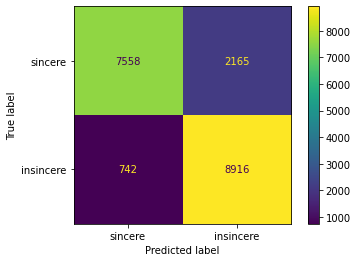

In [13]:
plot_confusion_matrix(model, test_x_tfidf, test_y, display_labels=['sincere', 'insincere'])

*F1_score = 0.86*

#### Not bad, in comparison to the original contest Leaderboard on Kaggle. Of course, that was on a larger dataset. However, the ration of the class labels was the same(before I actually took a subset). However, the model seems to be overfit in some way, because it doesn't do well on the actual test data.
-----------------------------------------------------

Now let me load the original test data and get the predictions. These predictions have to be submitted to the Kaggle contest.

Before that, let me use the entire training data and create another model. I will use this one for predictions and hope that I get a much higher accuracy on Kaggle

In [14]:
X = X.values.reshape(-1)
y = y.values.reshape(-1)

subm_vectorizer = TfidfVectorizer()
subm_X = subm_vectorizer.fit_transform(X)

subm_model = MultinomialNB()
subm_model.fit(subm_X, y)

del X, y

subm_model.class_count_

array([48451., 48451.])

In [15]:
test_data = pd.read_csv('dataset/test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522449 entries, 0 to 522448
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            522449 non-null  object
 1   question_text  522449 non-null  object
dtypes: object(2)
memory usage: 8.0+ MB


In [16]:
# Here I need the qid for submission. So I will separate it and convert to a 1D ndarray
test_ids = test_data[['qid']].values.reshape(-1)

# Get the questions, on which I will run the prediction
questions = test_data[['question_text']].values.reshape(-1)

In [17]:
# Get the TFIDF vector/matrix
text_questions = subm_vectorizer.transform(questions)

# Get the predictions from the model
test_predictions = subm_model.predict(text_questions)

In [18]:
# Create the submission Dataframe. This will give the csv file that I will submit
submission = pd.DataFrame([test_ids, test_predictions], ['qid', 'target']).transpose()

# Verify the format of the Dataframe
submission.head()

,qid,target
0,f56a9a31974dc66186e8,0
1,d957c3758060f45da303,0
2,ad822d5abaedb9e247b9,0
3,4e979c23eeb6a4bd1f2e,0
4,333cc031262566b8da49,0


In [19]:
# Verify the total number of rows and the dataframe in general
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522449 entries, 0 to 522448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   qid     522449 non-null  object
 1   target  522449 non-null  object
dtypes: object(2)
memory usage: 8.0+ MB


In [20]:
submission['target'].value_counts()

0    387534
1    134915
Name: target, dtype: int64

Now write the predictions to a csv file and submit it!

In [21]:
submission.to_csv('submissions/submission1_2109.csv', index=False)

One thing to remember is that the public leaderboard on Kaggle tests against 40% of the total test data only.

On this 40%:
The initial model achieved a F1 score of 0.35426.
The model trained model achieved a F1 score of 0.35796, a fractionally better performance.

F1 score is computed on the basis of *precision* and *recall*. Look these terms up later. A higher F1 score(closer to 1) is better. So the naive TFIDF method is no good.